### Data Science Report

This report investigates the relationship between residential gas usage and temperature fluctuations both inside and outside a single-family home in Noordwijk, NL, over a 19-month period. The gas consumption data was sourced from p1g meters, while internal temperature readings were collected using SmartThings sensors, and external temperature data was obtained from OpenMeteo. By integrating and analyzing these datasets, this study aims to enhance our understanding of how variations in both indoor and outdoor temperatures throughout the year influence gas consumption. Considering that building energy consumption accounts for approximately 40% of total energy usage in the United States, with similar figures globally, exploring energy efficiency and optimization in Smart Homes is essential. This investigation not only sheds light on energy dynamics within residential settings but also underscores the broader implications for sustainable energy management.

### Initialize Database Connection and Load the Data


In [69]:
# importing 
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import calendar
from scipy.stats import pearsonr


# git directories (delete?)
# Josh
gitdir = "/Users/joshd/Documents/GitHub/GA2024_1/"

#Magda
gitdir = "/Users/magdalenaskrzycki/Desktop/GA2024_1/"

module_path = os.path.abspath(gitdir)
sys.path.append(module_path)

from home_messages_db import HomeMessagesDB

db = HomeMessagesDB('sqlite:///myhome.db')

df_st = db.get_smartthings()
df_p1e = db.get_p1e()
df_p1g = db.get_p1g()
df_weather = db.get_weather_data()


### Data Preparation

In this section, we perform preprocessing and aggregation of the data. 
- indoor temperature 

    We filter the data from SmartThings sensors, convert the values to float, standardize column names, index by datetime, and calculate the average daily indoor temperatures. 
- outdoor temperature 

    We adjust the data types from OpenMeteo, rename columns for consistency, and obtain daily averages. 
- daily gas usage

    We convert the data obtained from p1g meters, convert it to float, remove missing values, index by datetime, calculate the daily usage (by comparing the first and last values of each day)

After preprocessing, we merge the data of the variables by time.

In [51]:
# select rows where the sensor capability is 'temperatureMeasurement'
df_ins_temp = df_st[df_st["capability"] == "temperatureMeasurement"]

# make a copy of the filtered dataframe to avoid modifying the original data
df_ins_temp = df_ins_temp.copy()

# convert temperature values from string to float
df_ins_temp['value'] = df_ins_temp['value'].astype(float)

# rename the 'value' column to 'inside temperature' 
df_ins_temp.rename(columns={'value': 'inside temperature'}, inplace=True)

# convert the 'epoch' column to datetime format 
df_ins_temp['datetime'] = pd.to_datetime(df_ins_temp['epoch'], unit='s')

# index by datetime
df_ins_temp.set_index('datetime', inplace=True)

# calculate daily averages
df_avg_house_temp_daily = df_ins_temp.resample('D').mean(numeric_only=True)

# reset the index to turn 'datetime' back into a column
df_avg_house_temp_daily.reset_index(inplace=True)

# select the columns columns 'datetime' and 'inside temperature'
df_avg_house_temp_daily = df_avg_house_temp_daily[['datetime', 'inside temperature']]


In [52]:
# convert the 'temperature_2m' data from string to float 
df_weather['temperature_2m'] = df_weather['temperature_2m'].astype(float)

# create a copy of the weather dataframe to prevent changes to the original data
df_out_temp = df_weather.copy()

# rename the 'temperature_2m' column to 'temperature' 
df_out_temp.rename(columns={'temperature_2m': 'temperature'}, inplace=True)

# convert the 'time' column to datetime format
df_out_temp['datetime'] = pd.to_datetime(df_out_temp['time'], unit='s')

# select the columns columns 'datetime' and 'temperature'
df_target = df_out_temp[['datetime', 'temperature']]

# set 'datetime' as the index 
df_target.set_index('datetime', inplace=True)

# calculate the daily mean of the outside temperature
df_daily_outside = df_target.resample('D').mean()

# reset the index to turn 'datetime' back into a column
df_daily_outside.reset_index(inplace=True)

In [53]:
# daily gas usage

# convert the 'total_gas_used' data from string to float
df_p1g['total_gas_used'] = df_p1g['total_gas_used'].astype(float)

# create a copy of the original dataframe to avoid changes to the original data
df_gas = df_p1g.copy()

# remove any rows with NAs
df_gas = df_gas.dropna(subset=['total_gas_used'])

# convert the 'time' column to datetime format
df_gas['datetime'] = pd.to_datetime(df_gas['time'])

# select the columns columns 'datetime' and 'total_gas_used'; set 'datetime' as the index
df_target = df_gas[['datetime', 'total_gas_used']]
df_target.set_index('datetime', inplace=True)

# find the first and last recorded gas usage of each day, calculate the difference
df_first = df_target.resample('D').first()
df_last = df_target.resample('D').last()
df_last_shifted = df_last.shift(-1)
df_daily_diff = df_last_shifted['total_gas_used'] - df_first['total_gas_used']

# remove NAs, reset the index, rename the columns
df_daily_diff = df_daily_diff.dropna()
df_daily_diff = df_daily_diff.reset_index()
df_daily_diff.rename(columns={'total_gas_used': 'daily_gas_difference'}, inplace=True)

In [54]:
# merging data sets
df_merge = pd.merge(df_avg_house_temp_daily, df_daily_outside, on='datetime', how='inner')
df_final = pd.merge(df_merge, df_daily_diff, on='datetime', how='inner')
df_final = df_final[['datetime','inside temperature', 'temperature','daily_gas_difference']]
df = df_final

### Descriptive Statistics

describe this more, i have only one month so it doesnt really show up in this table

We calculate the descriptive statistics of the three variables in order to understand their distributions. We provide visualizations that help understand the patterns of temperatures and gas usage.

In [55]:
# extract month from the datetime for grouping
df['month'] = df['datetime'].dt.month_name()

# calculate mean and standard deviation for inside temperature, outside temperature, and daily gas usage per month
monthly_stats = df.groupby('month').agg({
    'inside temperature': ['mean', 'std'],
    'temperature': ['mean', 'std'],
    'daily_gas_difference': ['mean', 'std']
})

# rename columns 
monthly_stats.columns = ['Inside Temp Mean', 'Inside Temp SD', 'Outside Temp Mean', 'Outside Temp SD', 'Gas Usage Mean', 'Gas Usage SD']

# sort the index by month order
month_order = {month: index for index, month in enumerate(calendar.month_name) if month}
monthly_stats = monthly_stats.reindex(sorted(monthly_stats.index, key=lambda x: month_order[x]))

formatted_monthly_stats = monthly_stats.applymap(lambda x: f"{x:.2f}")

print("Monthly Temperature and Gas Usage Statistics:")
print(formatted_monthly_stats)

Monthly Temperature and Gas Usage Statistics:
        Inside Temp Mean Inside Temp SD Outside Temp Mean Outside Temp SD  \
month                                                                       
October            19.95           0.72             13.75            1.77   

        Gas Usage Mean Gas Usage SD  
month                                
October           3.64         2.31  



here describe briefly the histograms and boxplots; adjust the bins for histograms; describe time series

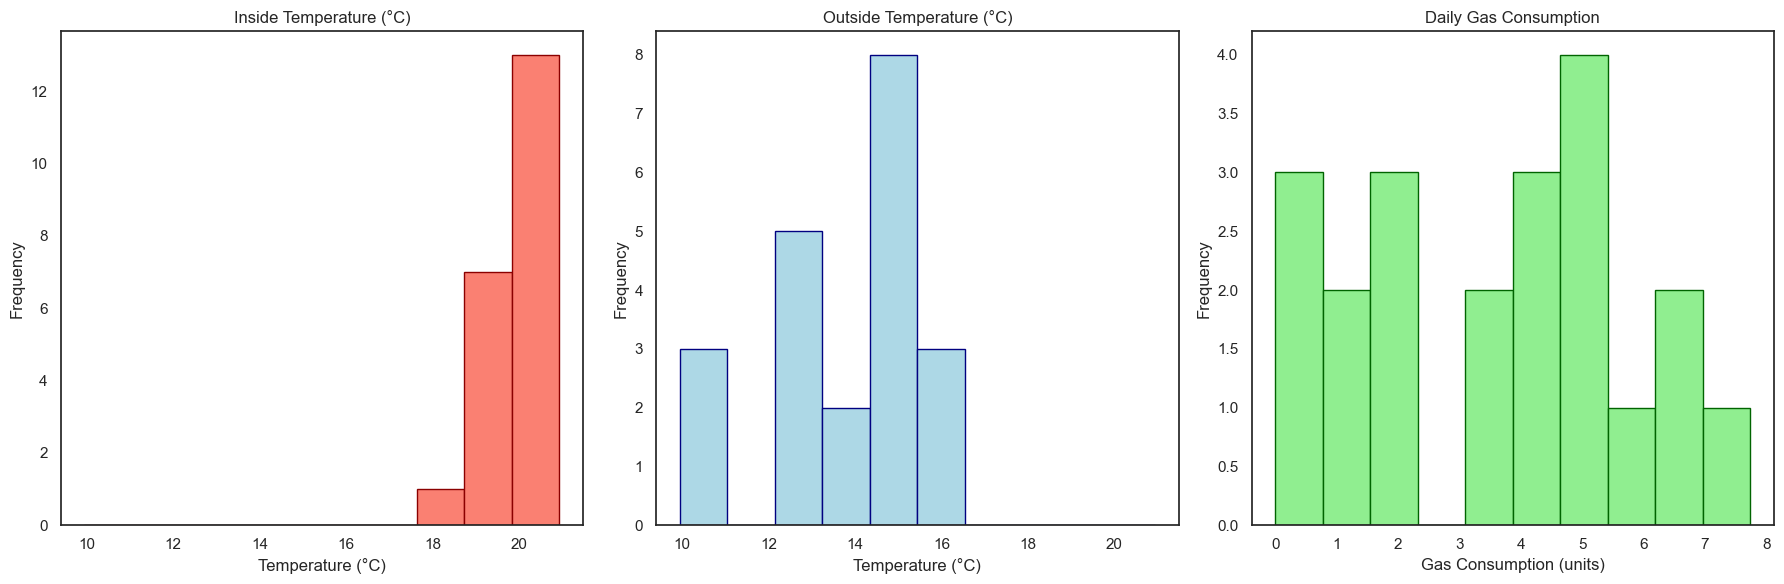

In [56]:
import matplotlib.pyplot as plt

# First, determine the min and max values across both temperature columns to set a common x-axis range
temp_min = min(df['inside temperature'].min(), df['temperature'].min())
temp_max = max(df['inside temperature'].max(), df['temperature'].max())

fig = plt.figure(figsize=(18, 6))

# Histogram for inside temperature
ax1 = fig.add_subplot(131)
ax1.hist(df['inside temperature'].dropna(), bins=10, color='salmon', edgecolor='darkred', range=(temp_min, temp_max))
ax1.set_title('Inside Temperature (°C)')
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('Frequency')

# Histogram for outside temperature
ax2 = fig.add_subplot(132)
ax2.hist(df['temperature'].dropna(), bins=10, color='lightblue', edgecolor='navy', range=(temp_min, temp_max))
ax2.set_title('Outside Temperature (°C)')
ax2.set_xlabel('Temperature (°C)')
ax2.set_ylabel('Frequency')

# Histogram for daily gas difference
ax3 = fig.add_subplot(133)
ax3.hist(df['daily_gas_difference'].dropna(), bins=10, color='lightgreen', edgecolor='darkgreen')
ax3.set_title('Daily Gas Consumption')
ax3.set_xlabel('Gas Consumption (units)')
ax3.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


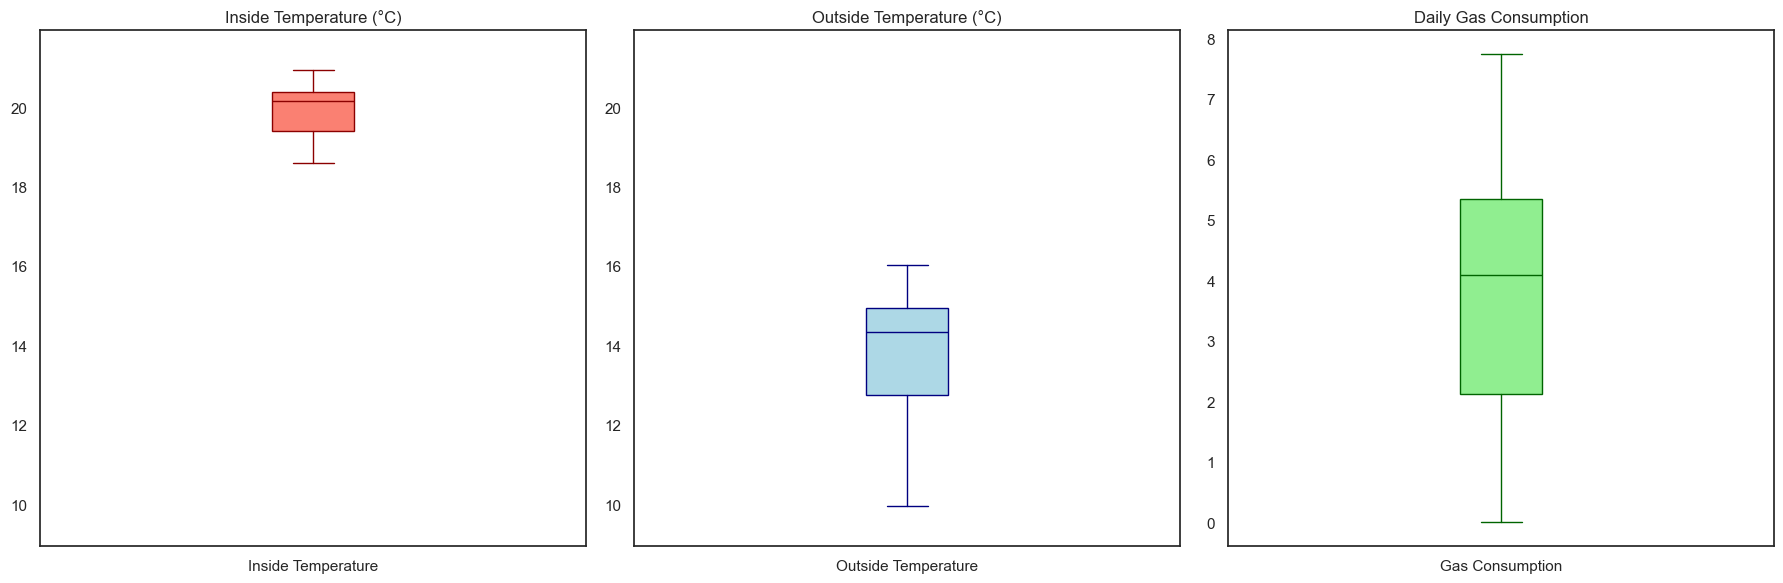

In [43]:
import matplotlib.pyplot as plt

# Determine the min and max values across both temperature columns to set a consistent axis scale
temp_min = min(df['inside temperature'].min(), df['temperature'].min()) - 1
temp_max = max(df['inside temperature'].max(), df['temperature'].max()) + 1

fig = plt.figure(figsize=(18, 6))

# Inside temperature plot with defined y-axis limits
ax1 = fig.add_subplot(131)
ax1.boxplot(df['inside temperature'].dropna(), patch_artist=True,
            boxprops=dict(facecolor='salmon', color='darkred'),
            medianprops=dict(color='darkred'),
            whiskerprops=dict(color='darkred'),
            capprops=dict(color='darkred'),
            flierprops=dict(marker='o', markerfacecolor='red', markersize=5, linestyle='none'))
ax1.set_ylim([temp_min, temp_max])  # Set consistent y-axis limits
ax1.set_title('Inside Temperature (°C)')
ax1.set_xticks([1])
ax1.set_xticklabels(['Inside Temperature'])

# Outside temperature plot with defined y-axis limits
ax2 = fig.add_subplot(132)
ax2.boxplot(df['temperature'].dropna(), patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='navy'),
            medianprops=dict(color='navy'),
            whiskerprops=dict(color='navy'),
            capprops=dict(color='navy'),
            flierprops=dict(marker='o', markerfacecolor='blue', markersize=5, linestyle='none'))
ax2.set_ylim([temp_min, temp_max])  # Set consistent y-axis limits
ax2.set_title('Outside Temperature (°C)')
ax2.set_xticks([1])
ax2.set_xticklabels(['Outside Temperature'])

# Daily gas difference plot
ax3 = fig.add_subplot(133)
ax3.boxplot(df['daily_gas_difference'].dropna(), patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='darkgreen'),
            medianprops=dict(color='darkgreen'),
            whiskerprops=dict(color='darkgreen'),
            capprops=dict(color='darkgreen'),
            flierprops=dict(marker='o', markerfacecolor='green', markersize=5, linestyle='none'))
ax3.set_title('Daily Gas Consumption')
ax3.set_xticks([1])
ax3.set_xticklabels(['Gas Consumption'])

plt.tight_layout()
plt.show()


### Correlation Analysis

some description for correlation matrix + testing for significance

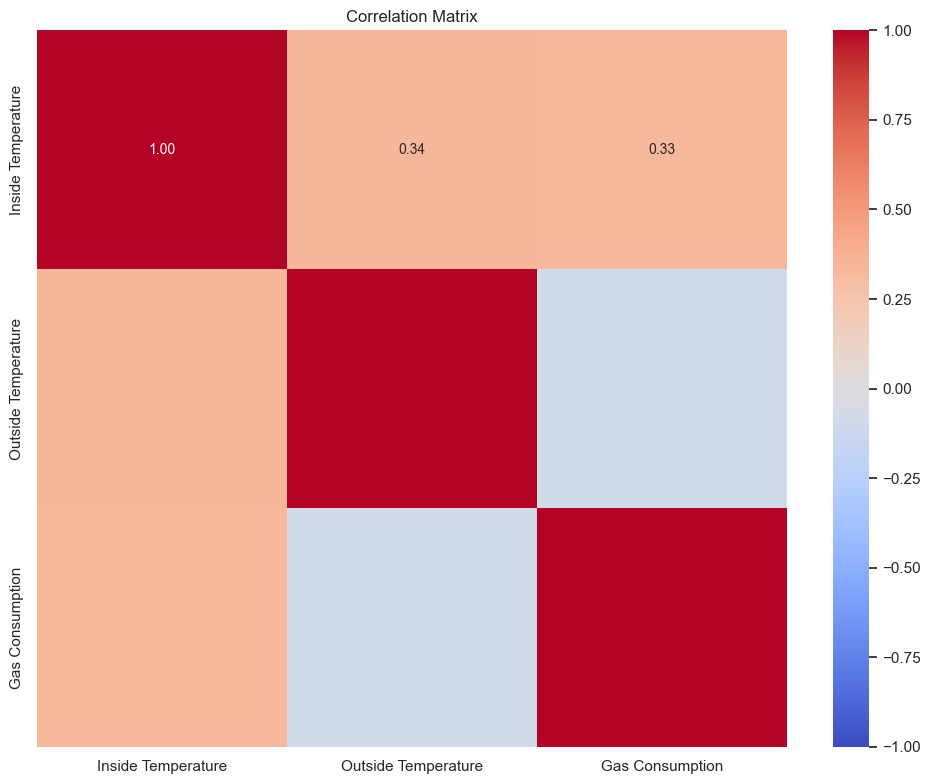

In [57]:
df_renamed = df.rename(columns={
    'inside temperature': 'Inside Temperature',
    'temperature': 'Outside Temperature',
    'daily_gas_difference': 'Gas Consumption'
})
correlation_matrix = df_renamed[['Inside Temperature', 'Outside Temperature', 'Gas Consumption']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', annot_kws={"size": 10}, vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.tight_layout()  
plt.show()


In [70]:
# calculating Pearson's correlation and the p-value between 'inside temperature' and 'daily_gas_difference'
correlation, p_value = pearsonr(df['inside temperature'], df['daily_gas_difference'])
print(f"Correlation: {correlation}, P-value: {p_value}")

# calculating Pearson's correlation and the p-value between 'outside temperature' and 'daily_gas_difference'
correlation, p_value = pearsonr(df['temperature'], df['daily_gas_difference'])
print(f"Correlation: {correlation}, P-value: {p_value}")

# calculating Pearson's correlation and the p-value between 'inside temperature' and 'outside temperature'
correlation, p_value = pearsonr(df['inside temperature'], df['temperature'])
print(f"Correlation: {correlation}, P-value: {p_value}")

Correlation: 0.3330053428597799, P-value: 0.1401960873204766
Correlation: -0.09352806125145728, P-value: 0.6867710805719413
Correlation: 0.3436991037404611, P-value: 0.12713588919815763


### Regression Analysis
We investigate the relationship between daily gas consumption and both inside and outside temperatures using Ordinary Least Squares (OLS) regression. As OLS depends on assumptions including normality and homoskedasticity of residuals, we provide the relevant checks below. 

To assess the contributions of the predictors we introduce two reduced models: one  excluding inside temperature and the other excluding ourside temperature. To evaluate the significance of the variables, we perform Likelihood Ratio Tests (LRT) between the full model and each of the reduced models. These tests provide an insight into how much each temperature variable independently affects daily gas consumption. The tests have the following hypotheses:
- Exluding inside temperature:

    H0: Excluding 'inside temperature' from the full model does not significantly worsen the model's fit.
    
    Ha: Excluding 'inside temperature' significantly worsens the model's fit, indicating that 'inside temperature' provides important information for predicting daily gas differences.

- Exluding outside temperature: 

    H0: Excluding 'outside temperature' from the full model does not significantly worsen the model's fit.

    Ha: Excluding 'outside temperature' significantly worsens the model's fit, indicating that 'inside temperature' provides important information for predicting daily gas differences.


Add conclusions!

In [45]:
df_clean = df.dropna(subset=['inside temperature', 'temperature', 'daily_gas_difference'])
X = df_clean[['inside temperature', 'temperature']]  
X = sm.add_constant(X)  
y = df_clean['daily_gas_difference']  
model = sm.OLS(y, X).fit()
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     daily_gas_difference   R-squared:                       0.160
Model:                              OLS   Adj. R-squared:                  0.067
Method:                   Least Squares   F-statistic:                     1.714
Date:                  Fri, 07 Jun 2024   Prob (F-statistic):              0.208
Time:                          00:14:41   Log-Likelihood:                -45.017
No. Observations:                    21   AIC:                             96.03
Df Residuals:                        18   BIC:                             99.17
Df Model:                             2                                         
Covariance Type:              nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const           

In [46]:
# reduced Model excluding 'inside temperature'
X_reduced1 = df_clean[['temperature']]
X_reduced1 = sm.add_constant(X_reduced1)  # adding a constant
model_reduced1 = sm.OLS(y, X_reduced1).fit()

# reduced Model excluding 'temperature'
X_reduced2 = df_clean[['inside temperature']]
X_reduced2 = sm.add_constant(X_reduced2)  # adding a constant
model_reduced2 = sm.OLS(y, X_reduced2).fit()

# Likelihood Ratio Test for both reduced models
from scipy.stats import chi2
def perform_lrt(model, reduced_model):
    lr_stat = -2 * (reduced_model.llf - model.llf)
    p_value = chi2.sf(lr_stat, df=model.df_model - reduced_model.df_model)
    return lr_stat, p_value

lr_stat1, p_value1 = perform_lrt(model, model_reduced1)
lr_stat2, p_value2 = perform_lrt(model, model_reduced2)

print(f"Likelihood Ratio Statistic (excluding 'inside temperature'): {lr_stat1}, p-value: {p_value1}")
print(f"Likelihood Ratio Statistic (excluding 'temperature'): {lr_stat2}, p-value: {p_value2}")


Likelihood Ratio Statistic (excluding 'inside temperature'): 3.475497037849351, p-value: 0.062284008145536175
Likelihood Ratio Statistic (excluding 'temperature'): 1.1917215889235138, p-value: 0.27498256629020845


### Assumption checks
For OLS, it is essential to perform checks for normality of residuals and homoskedasticity. 

(describe the result here: 
- it is normal if qqplots are on the red line; 
- scatter plot should have no pattern for homoskedaciticty
- also the histogram should be bell shapes)


Text(0.5, 1.0, 'Q-Q plot of model residuals')

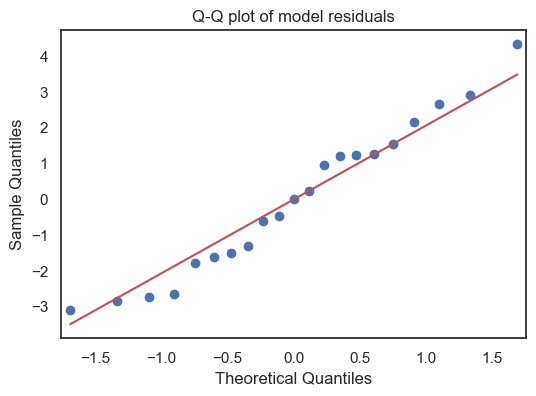

In [66]:
# Plotting Q-Q plot to check normality of residuals
fig, ax = plt.subplots(figsize=(6, 4))
sm.qqplot(model.resid, line='s', ax=ax)  
ax.set_title('Q-Q plot of model residuals')

Text(0.5, 1.0, 'Residuals vs Predicted values')

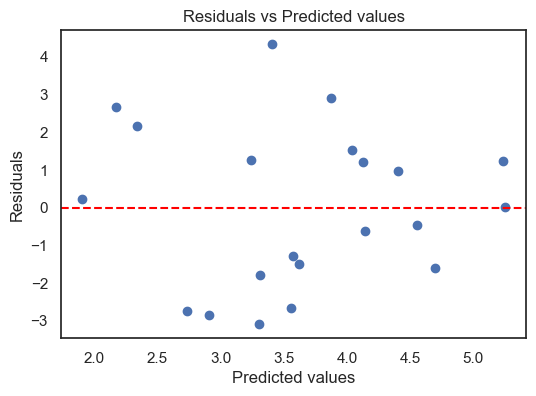

In [59]:
# Check for homoscedasticity
# Scatter plot of residuals versus predicted values
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(model.fittedvalues, model.resid)
ax.axhline(y=0, color='red', linestyle='--')
ax.set_xlabel('Predicted values')
ax.set_ylabel('Residuals')
ax.set_title('Residuals vs Predicted values')

Text(0, 0.5, 'Frequency')

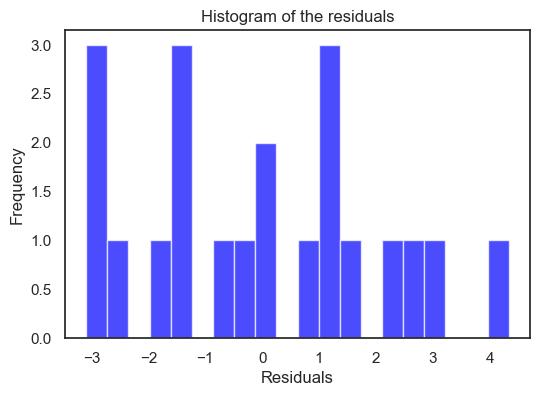

In [67]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(model.resid, bins=20, color='blue', alpha=0.7)
ax.set_title('Histogram of the residuals')
ax.set_xlabel('Residuals')
ax.set_ylabel('Frequency')

### Conclusion

summarize the findings (correlation, significance of ecoeffeicients in predicting gas usage)